# Sentinel-2 Image Retrieval Using Google Earth Engine

To retrieve Sentinel-2 images from Google Earth Engine, make sure you create an account and authenticate prior to running the cell below. The link to sign up is [here](https://earthengine.google.com/new_signup/).



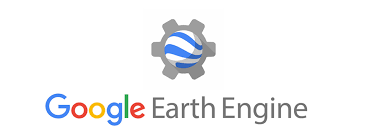

To download Sentinel-2 images we will be using the module <code>ee_download</code> and interact with the map using <code>geemap.eefolium</code>.

We use the AOI polygons retrieved from CopernicusEMS to select the location and time that we are interested in and use Google Earth Engine to do the georeferencing. Notice that we may also render the hydrography and observed flood event.

In [16]:
# Path based modules to allow us to save files to our local machine
from pyprojroot import here
import sys
import os
root = here(project_files=[".here"])
sys.path.append(str(here()))

In [22]:
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from src.data import ee_download
from src.data.copernicusEMS import activations

In [24]:
floodmap = gpd.read_file('floodmap.geojson')

import pickle
with open('metadata_floodmap.data', 'rb') as filehandle:
    # read the data as binary data stream
    metadata_floodmap = pickle.load(filehandle)

In [25]:
floodmap

,w_class,source,geometry
0,Flooded area,flood,"MULTIPOLYGON (((9.71259 40.64228, 9.71245 40.6..."
1,Flooded area,flood,"MULTIPOLYGON (((9.65320 40.62754, 9.65318 40.6..."
2,Flooded area,flood,"POLYGON ((9.64421 40.62988, 9.64411 40.62988, ..."
3,Flooded area,flood,"MULTIPOLYGON (((9.70369 40.63643, 9.70363 40.6..."
4,Flooded area,flood,"MULTIPOLYGON (((9.69035 40.63546, 9.69030 40.6..."
...,...,...,...
91,BH140-River,hydro_l,"LINESTRING (9.70625 40.63070, 9.70623 40.63075)"
92,BH140-River,hydro_l,"LINESTRING (9.70660 40.62900, 9.70660 40.62946..."
93,BH140-River,hydro_l,"LINESTRING (9.71038 40.62231, 9.71121 40.62346..."
94,BH140-River,hydro_l,"LINESTRING (9.64349 40.62817, 9.64382 40.62808..."


In [26]:
ee.Initialize()

bounds_pol = activations.generate_polygon(metadata_floodmap["area_of_interest_polygon"].bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

# pol with the real area of interest
x, y = metadata_floodmap["area_of_interest_polygon"].exterior.coords.xy
pol_list = list(zip(x,y))
pol = ee.Geometry.Polygon(pol_list)

date_event = datetime.utcfromtimestamp(metadata_floodmap["satellite date"].timestamp())

date_end_search = date_event + timedelta(days=20)

img_col = ee_download.get_s2_collection(date_event, date_end_search, pol)

n_images_col = img_col.size().getInfo()
print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")
Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    img_show = ee.Image(imgs_list.get(i))
    # print(img_show.bandNames().getInfo())
    Map.addLayer(img_show.clip(pol_2_clip), 
                 {"min":0, "max":3000, "bands":["B4","B3","B2"]},f"S2 {i}", True)

geojson_file = "geojson_show.geojson"
floodmap.to_file(geojson_file, driver="GeoJSON")
Map.add_geojson(geojson_file,name="FloodMap")

Map.centerObject(pol)
folium.LayerControl(collapsed=False).add_to(Map)
# Map.addLayerControl()
Map

Found 3 S2 images between 2020-12-03T10:01:31 and 2020-12-23T10:01:31


## Export Sentinel-2 Images to the Google Cloud Bucket

Looking at the S2 images in the map, we see that the second image (S2.1) is the less cloudy of the three images retrieved by the Google Earth Engine. We will export that to the Google bucket to further inspect it. Use <code>task</code> to monitor the status. To run this part of the code you'd need access to the ml4floods Google bucket.

In [27]:
import os

BANDS_EXPORT = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA60', 'probability']

img_export = ee.Image(imgs_list.get(1))

img_export = img_export.select(BANDS_EXPORT).toFloat().clip(pol_2_clip) # .reproject(crs,scale=10).resample('bicubic') resample cannot be used on composites

# TODO in the future, change to export to drive and mount the Google drive in colab!

bucket_name= "ml4floods"

export_task_fun_img = ee_download.export_task_image(bucket=bucket_name)

filename = os.path.join("preingest", "S2", "sardinia")
desc = os.path.basename(filename) + "S2"
task = ee_download.mayberun(filename, desc,
                            lambda : img_export,
                            export_task_fun_img,
                            overwrite=False, dry_run=False,
                            bucket_name=bucket_name, verbose=2)
if task is not None:
    task.status()

	File preingest/S2/sardinia exists in the bucket, it will not be downloaded


In [ ]:
# Refresh this cell until the state of the task is completed!
task.status()

## Retrieve Images from Bucket

To demonstrate that the images have been successfully uploaded to the Google Cloud Storage bucket, we open the image using <code>rasterio</code>. 

In [29]:
from src.data import create_gt
import rasterio

image_name = f"gs://{bucket_name}/{filename}.tif"
with rasterio.open(image_name) as src:
    print(src.shape)
    image = src.read()
    transform = src.transform

image.shape

(384, 1012)


(15, 384, 1012)

In [30]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 10)

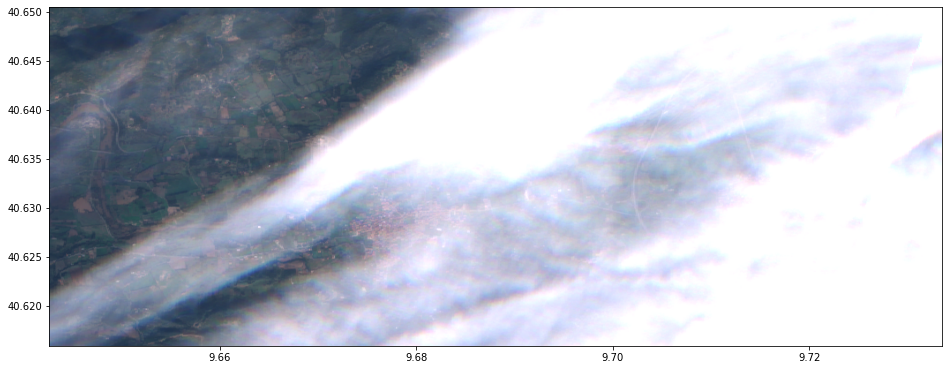

<AxesSubplot:>

In [31]:
from rasterio import plot as rasterioplt
import numpy as np

rgb = np.clip(image[(3,2,1),...]/3000.,0,1)
    
rasterioplt.show(rgb, transform=transform)